In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error


df = pd.read_csv("selected_sales.csv")

In [3]:
# Convert ticket_end_time to datetime if it's not already
df["ticket_end_time"] = pd.to_datetime(df["ticket_end_time"])

# Set ticket_end_time as the index
df.set_index("ticket_end_time", inplace=True)

In [4]:
#Create time-based features
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week

In [5]:
#Calculate rolling averages
df['sales_qty_7day_avg'] = df.groupby('article_code')['sales_qty_base_uom'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['sales_qty_30day_avg'] = df.groupby('article_code')['sales_qty_base_uom'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

In [6]:
#Create lag features
df['sales_qty_lag1'] = df.groupby('article_code')['sales_qty_base_uom'].shift(1)
df['sales_qty_lag7'] = df.groupby('article_code')['sales_qty_base_uom'].shift(7)

In [7]:
#Derive features from article data
# Assuming 'article_desc' contains information about brand and category
df['brand'] = df['article_desc'].str.split().str[0]

In [8]:
# Create a price category based on the average price of the article
df['avg_price'] = df.groupby('article_code')['sales_qty_base_uom'].transform('mean')
df['price_category'] = pd.qcut(df['avg_price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [9]:
df.head()

,date_key,unique_ticket_id,article_code,sales_qty_alternate_uom,alternate_uom,sales_qty_base_uom,base_uom_x,article_desc,base_uom_y,super_dept_no,...,month,day_of_month,week_of_year,sales_qty_7day_avg,sales_qty_30day_avg,sales_qty_lag1,sales_qty_lag7,brand,avg_price,price_category
ticket_end_time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 08:09:12,20220103,c6b2b8c8-1b52-4375-b065-79e48933fab6,10164184,1.0,EA,1.0,EA,"SOFT DRNK TWIST 2L, GDILLA",EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,SOFT,1.101184,Low
2022-01-03 08:09:43,20220103,45bc7474-a244-4c5a-b5c1-584f8662d1f2,10722932,1.0,EA,1.0,EA,"ENERGY DRINK SCORE 500ML, PASSIONFRT",EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,ENERGY,1.114583,Medium
2022-01-03 08:09:59,20220103,150a9040-fb3b-4b4e-9170-17d8af09e725,10143154,1.0,EA,1.0,EA,WATER STILL BONAQUA 500ML,EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,WATER,1.172748,High
2022-01-03 08:11:10,20220103,175b9537-94ee-416d-9ccc-d17ddb2141d0,10722932,1.0,EA,1.0,EA,"ENERGY DRINK SCORE 500ML, PASSIONFRT",EA,10,...,1.0,3.0,1,1.0,1.0,1.0,NaN,ENERGY,1.114583,Medium
2022-01-03 08:17:49,20220103,1676c7fc-a26a-4f4c-8bb2-7a89386b81f5,10551096,3.0,EA,3.0,EA,COFFEE INSTNT NESCAFE GOLD 1.8G,EA,10,...,1.0,3.0,1,3.0,3.0,NaN,NaN,COFFEE,3.046997,Very High


### creating a training and testing split (last 6 months)

In [11]:
best_articles = {10538314, 10248591, 10538316, 10156064, 10725085, 10141470, 10142968, 10125869, 10133205, 10138799, 10130258, 10124088}



/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but 

Validation MAE: 0.16398277942292497
Validation MSE: 0.30078430444761517


/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


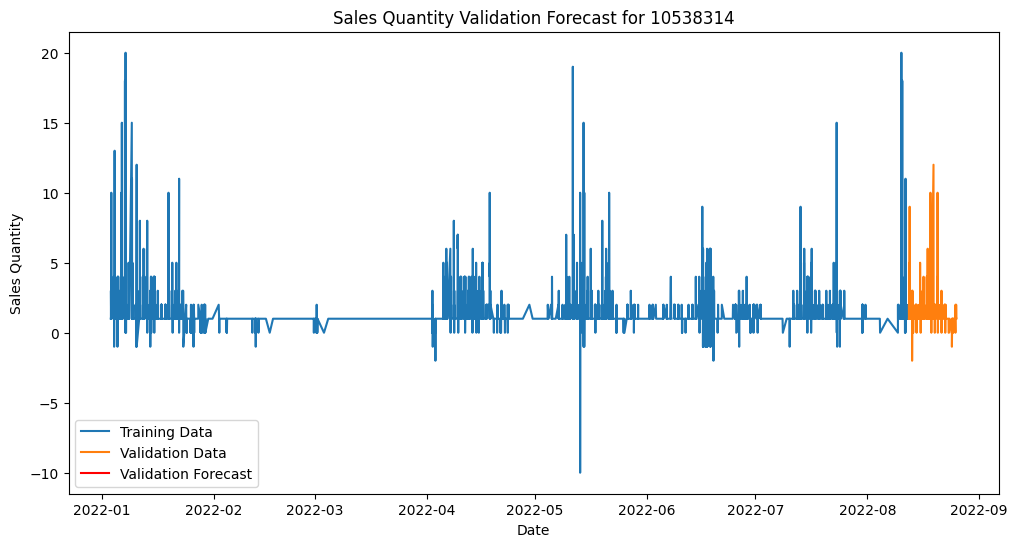

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but 

Test MAE: 0.31700318029528685
Test MSE: 0.367164431247365


/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


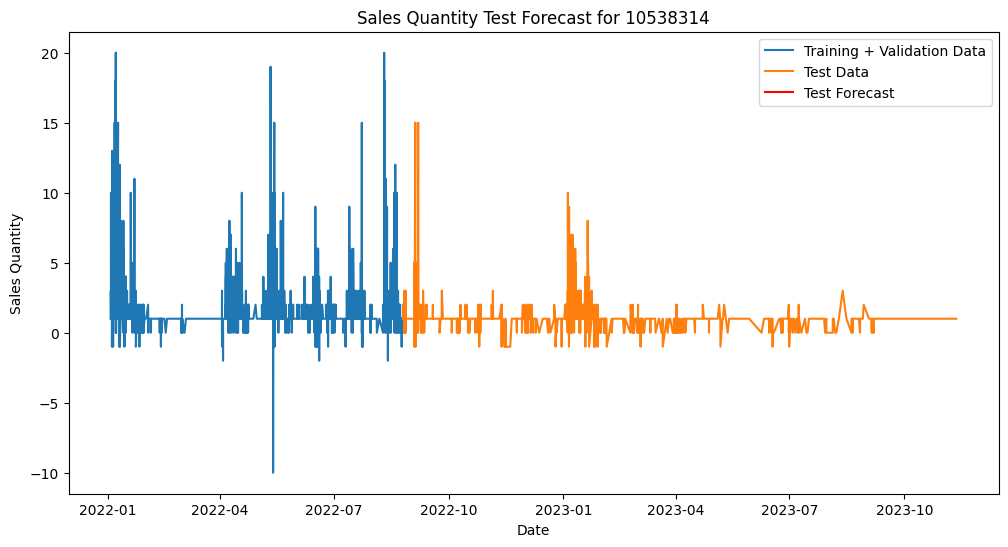

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but 

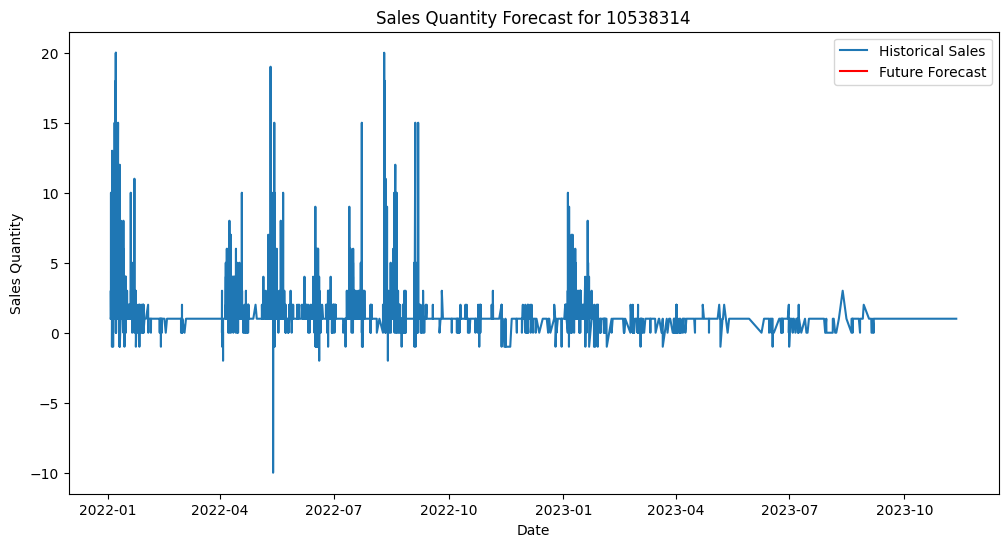

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df is the DataFrame you provided
# Define the best articles
best_articles = {10538314, 10248591, 10538316, 10156064, 10725085, 10141470, 10142968, 10125869, 10133205, 10138799, 10130258, 10124088}

# Select the first best article
article_code = 10538314

# Filter the data for the selected article
product_data = df[df["article_code"] == article_code]

# Ensure the index is of datetime type
product_data.index = pd.to_datetime(product_data.index)

# Split data into training (70%), validation (10%), and test sets (20%)
n = len(product_data)
train_size = int(n * 0.7)
validation_size = int(n * 0.1)

train = product_data.iloc[:train_size]
validation = product_data.iloc[train_size : train_size + validation_size]
test = product_data.iloc[train_size + validation_size :]

# Fit ARIMA model on the training data
# Example order (5,1,0) for ARIMA(p, d, q) where d=1 for first differencing
product_model = ARIMA(train["sales_qty_base_uom"], order=(5, 1, 0))
product_model_fit = product_model.fit()

# Forecast on the validation set
validation_forecast = product_model_fit.forecast(steps=len(validation))
validation_forecast_df = pd.DataFrame(validation_forecast, index=validation.index, columns=["Forecast"])

# Calculate evaluation metrics for validation set
mae_validation = mean_absolute_error(validation["sales_qty_base_uom"], validation_forecast)
mse_validation = mean_squared_error(validation["sales_qty_base_uom"], validation_forecast)
print(f"Validation MAE: {mae_validation}")
print(f"Validation MSE: {mse_validation}")

# Plot the validation forecast
plt.figure(figsize=(12, 6))
plt.plot(train["sales_qty_base_uom"], label="Training Data")
plt.plot(validation["sales_qty_base_uom"], label="Validation Data")
plt.plot(validation_forecast_df, label="Validation Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Validation Forecast for {article_code}")
plt.legend()
plt.show()

# Fit the model on the training + validation set
train_validation = pd.concat([train, validation])
product_model = ARIMA(train_validation["sales_qty_base_uom"], order=(5, 1, 0))
product_model_fit = product_model.fit()

# Forecast on the test set
test_forecast = product_model_fit.forecast(steps=len(test))
test_forecast_df = pd.DataFrame(test_forecast, index=test.index, columns=["Forecast"])

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(test["sales_qty_base_uom"], test_forecast)
mse_test = mean_squared_error(test["sales_qty_base_uom"], test_forecast)
print(f"Test MAE: {mae_test}")
print(f"Test MSE: {mse_test}")

# Plot the test forecast
plt.figure(figsize=(12, 6))
plt.plot(train_validation["sales_qty_base_uom"], label="Training + Validation Data")
plt.plot(test["sales_qty_base_uom"], label="Test Data")
plt.plot(test_forecast_df, label="Test Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Test Forecast for {article_code}")
plt.legend()
plt.show()

# Forecast the next 180 days using the model fit on the full dataset
full_model = ARIMA(product_data["sales_qty_base_uom"], order=(5, 1, 0))
full_model_fit = full_model.fit()
future_forecast = full_model_fit.forecast(steps=180)
forecast_index = pd.date_range(start=product_data.index[-1] + timedelta(days=1), periods=180, freq="D")
future_forecast_df = pd.DataFrame(future_forecast, index=forecast_index, columns=["Forecast"])

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(product_data["sales_qty_base_uom"], label="Historical Sales")
plt.plot(future_forecast_df, label="Future Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Forecast for {article_code}")
plt.legend()
plt.show()